<a href="https://colab.research.google.com/github/koushik980/NLP/blob/main/NLP_F_10_10_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Synthetic dataset created with 500 documents.
Built graph with 56 nodes and 172 edges.

Sample SVO triples (first 20):
 - ('augmentation', 'improve', 'generalization')
 - ('learning', 'increase', 'performance')
 - ('augmentation', 'improve', 'generalization')
 - ('learning', 'increase', 'performance')
 - ('augmentation', 'improve', 'generalization')
 - ('network', 'show', 'result')
 - ('network', 'show', 'result')
 - ('augmentation', 'improve', 'generalization')
 - ('learning', 'improve', 'analysis')
 - ('learning', 'improve', 'analysis')
 - ('learning', 'increase', 'performance')
 - ('learning', 'increase', 'performance')
 - ('augmentation', 'improve', 'generalization')
 - ('learning', 'increase', 'performance')
 - ('augmentation', 'improve', 'generalization')
 - ('network', 'show', 'result')
 - ('network', 'show', 'result')
 - ('augmentation', 'improve', 'generalization')
 - ('network', 'show', 'result')
 - ('learning', 'increase', 'performance')


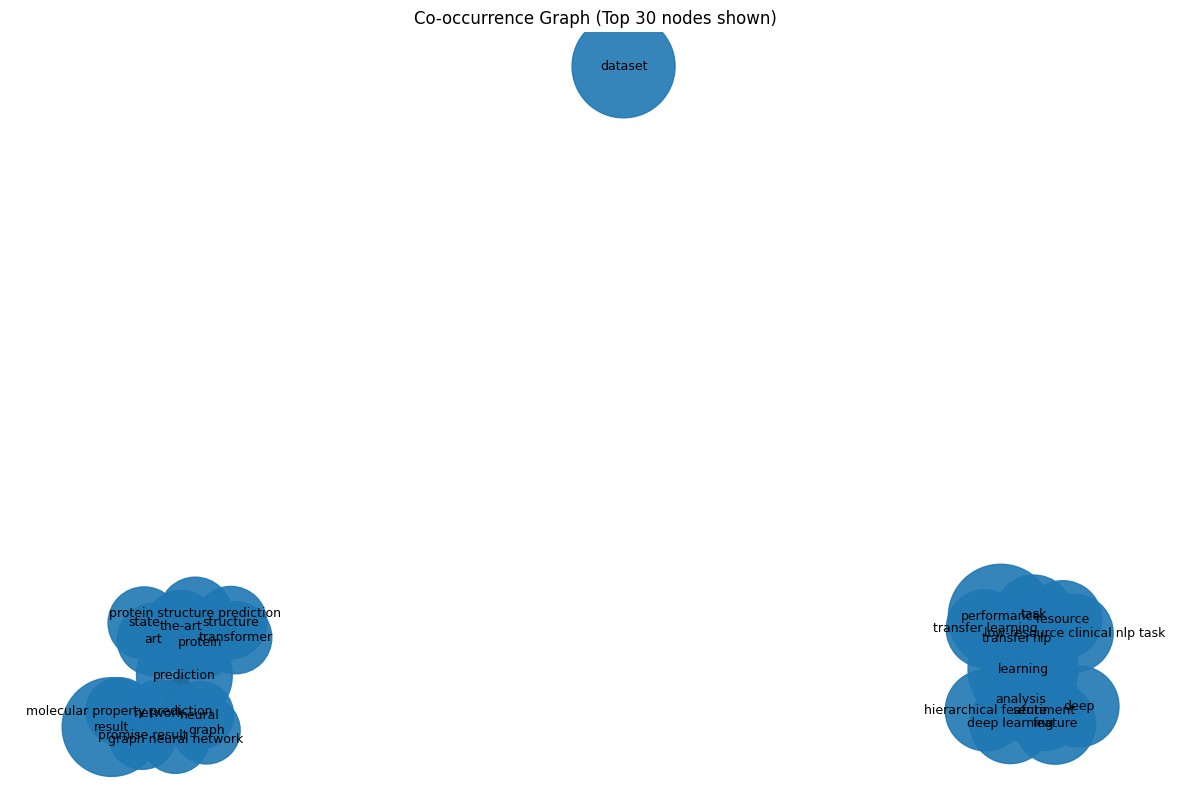

Saved centrality table to: centrality_all_nodes.csv

Top central nodes (aggregated ranks):
                          node  count  degree_centrality  betweenness_centrality  pagerank  eigenvector
                    prediction     89           0.272727                0.047138  0.032549          0.0
                      learning    119           0.236364                0.044444  0.032261          0.0
                   performance    108           0.200000                0.035017  0.028898          0.0
                       dataset    104           0.145455                0.010101  0.029709          0.0
                        result     95           0.181818                0.020202  0.025502          0.0
                      resource     57           0.127273                0.000000  0.017890          0.0
                          task     57           0.127273                0.000000  0.017890          0.0
low-resource clinical nlp task     57           0.127273                0.000

In [2]:
import os
import re
import math
import pickle
import pandas as pd
import numpy as np
import spacy
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
DATA_PATH = "cord19_abstracts.csv"   # CSV expected to have column 'abstract'
TEXT_COLUMN = "abstract"
MIN_ENTITY_LEN = 2                   # minimum length (chars) for entity tokens
TOP_N_DISPLAY = 30                   # for plotting: number of top nodes to show
TOP_K_CENTRAL = 10                   # top-K central nodes to print
SPACY_MODEL = "en_core_web_sm"       # spaCy model
OUTPUT_GRAPH_GPKL = "cooccurrence_graph.gpickle"
OUTPUT_CENTRALITY_CSV = "centrality_all_nodes.csv"
# -----------------------------------------------

# Load spaCy model (exit with helpful message if missing)
try:
    nlp = spacy.load(SPACY_MODEL)
except Exception as e:
    raise SystemExit(
        f"spaCy model '{SPACY_MODEL}' is not available. Install with:\n"
        f"  pip install spacy\n"
        f"  python -m spacy download {SPACY_MODEL}\n\nOriginal error: {e}"
    )

def create_synthetic_sample(n=500, seed=42):
    """Create a small synthetic abstracts dataset if real file is not present."""
    np.random.seed(seed)
    positives = [
        "Deep learning improves sentiment analysis by learning hierarchical features.",
        "Graph neural networks show promising results for molecular property prediction.",
        "Transfer learning increases performance in low-resource clinical NLP tasks.",
        "Transformer architectures achieve state-of-the-art on protein structure prediction.",
        "Data augmentation improves generalization for small datasets."
    ]
    negatives = [
        "Method fails on out-of-distribution examples and needs further study.",
        "The dataset is noisy and labels are inconsistent across annotators.",
        "Model performance drops sharply in adversarial settings.",
        "This approach is not suitable for real-time deployment due to latency.",
        "Results are inconclusive and require additional experiments."
    ]
    rows = []
    for i in range(n):
        text = np.random.choice(positives + negatives)
        rows.append({"abstract": text})
    return pd.DataFrame(rows)

def load_data(path=DATA_PATH, text_col=TEXT_COLUMN):
    """Load dataset or fallback to synthetic sample (with message)."""
    if os.path.exists(path):
        df = pd.read_csv(path)
        if text_col not in df.columns:
            raise ValueError(f"File found but missing required column '{text_col}'. Columns: {list(df.columns)}")
        df = df[[text_col]].dropna().rename(columns={text_col: "text"})
        print(f"Loaded {len(df)} documents from {path}")
    else:
        print(f"WARNING: Data file '{path}' not found. Creating a synthetic sample for demo.")
        df = create_synthetic_sample(n=500)
        df = df.rename(columns={"abstract": "text"})
        print(f"Synthetic dataset created with {len(df)} documents.")
    return df

def clean_text(text):
    """Basic text cleaning."""
    text = str(text).replace("\n", " ").strip()
    text = re.sub(r"\s+", " ", text)
    return text

def extract_entities_from_sentence(sent_span, min_len=MIN_ENTITY_LEN):
    """
    Extract entity candidates from a sentence:
    - prefer noun_chunks (multi-word noun phrases)
    - also include single nouns/proper nouns not in noun_chunks
    Return a list of normalized entity strings.
    """
    ents = []
    # noun_chunks sometimes include determiners/pronouns; use lemma form and lowercase
    for nc in sent_span.noun_chunks:
        s = nc.lemma_.lower().strip()
        s = re.sub(r"[^a-z0-9\s\-]", "", s)
        if len(s) >= min_len and not s.isdigit():
            if s not in ents:
                ents.append(s)
    for token in sent_span:
        if token.pos_ in ("NOUN", "PROPN") and token.lemma_:
            s = token.lemma_.lower().strip()
            s = re.sub(r"[^a-z0-9\s\-]", "", s)
            if len(s) >= min_len and s not in ents:
                ents.append(s)
    return ents

def extract_svo_from_sentence(sent_span):
    """
    Lightweight SVO extraction:
    For each verb token, look for nominal subject and (direct) object children.
    Returns list of (subj_lemma, verb_lemma, obj_lemma)
    """
    svos = []
    for token in sent_span:
        if token.pos_ == "VERB":
            subj = None
            obj = None
            # check children
            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass") and child.pos_ in ("NOUN", "PROPN", "PRON"):
                    subj = child
                if child.dep_ in ("dobj", "obj", "pobj") and child.pos_ in ("NOUN", "PROPN"):
                    obj = child
            if subj is not None and obj is not None:
                svos.append((subj.lemma_.lower(), token.lemma_.lower(), obj.lemma_.lower()))
    return svos

def build_cooccurrence_graph(texts):
    """
    Build an undirected co-occurrence graph where:
      - nodes: entity strings (noun phrases / nouns)
      - edges: increment weight when two entities co-occur in the same sentence
    Also collects SVO triples encountered.
    """
    G = nx.Graph()
    cooc_counts = Counter()
    node_counts = Counter()
    relations = []

    # iterate with spaCy pipe for speed
    for doc in nlp.pipe(texts, disable=["ner"]):
        for sent in doc.sents:
            sent_doc = sent.as_doc()  # treat span like doc for convenience
            ents = extract_entities_from_sentence(sent_doc)
            # update node counts
            for e in ents:
                node_counts[e] += 1
            # update co-occurrence
            for i in range(len(ents)):
                for j in range(i+1, len(ents)):
                    a, b = ents[i], ents[j]
                    if a == b:
                        continue
                    key = tuple(sorted([a, b]))
                    cooc_counts[key] += 1
            # extract SVOs
            svos = extract_svo_from_sentence(sent_doc)
            for s, v, o in svos:
                relations.append((s, v, o))

    # add nodes and node attributes
    for node, cnt in node_counts.items():
        G.add_node(node, count=cnt)
    # add edges with weights
    for (a, b), w in cooc_counts.items():
        G.add_edge(a, b, weight=w)

    print(f"Built graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G, relations

def visualize_graph_nx(G, top_n=TOP_N_DISPLAY, figsize=(12, 8), seed=42):
    """
    Visualize a reduced version of the graph (top_n by degree) using NetworkX and matplotlib.
    """
    if G.number_of_nodes() == 0:
        print("Graph is empty, nothing to visualize.")
        return

    # choose top-n nodes by weighted degree
    deg = dict(G.degree(weight='weight'))
    sorted_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)
    top_nodes = set([n for n, _ in sorted_nodes[:top_n]])
    H = G.subgraph(top_nodes).copy()

    pos = nx.spring_layout(H, seed=seed, k=0.5)
    edge_weights = [max(0.5, H[u][v].get('weight', 1)) for u, v in H.edges()]
    node_sizes = [300 + 50 * H.nodes[n].get('count', 0) for n in H.nodes()]

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(H, pos, width=[math.log(w+1) for w in edge_weights], alpha=0.6)
    nx.draw_networkx_labels(H, pos, font_size=9)
    plt.title(f"Co-occurrence Graph (Top {len(H.nodes())} nodes shown)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def compute_and_save_centralities(G, out_csv=OUTPUT_CENTRALITY_CSV, top_k=TOP_K_CENTRAL):
    """
    Compute degree centrality, betweenness, pagerank and eigenvector centrality.
    Return top-k nodes by aggregated rank.
    """
    if G.number_of_nodes() == 0:
        return pd.DataFrame(), pd.DataFrame()

    deg_cent = nx.degree_centrality(G)
    bet_cent = nx.betweenness_centrality(G, weight='weight', normalized=True)
    try:
        pr = nx.pagerank(G, weight='weight')
    except Exception:
        pr = {n: 0.0 for n in G.nodes()}
    try:
        eig = nx.eigenvector_centrality_numpy(G, weight='weight')
    except Exception:
        eig = {n: 0.0 for n in G.nodes()}

    rows = []
    for n in G.nodes():
        rows.append({
            "node": n,
            "count": G.nodes[n].get('count', 0),
            "degree_centrality": deg_cent.get(n, 0),
            "betweenness_centrality": bet_cent.get(n, 0),
            "pagerank": pr.get(n, 0),
            "eigenvector": eig.get(n, 0)
        })
    df = pd.DataFrame(rows)
    # rank and aggregate
    for col in ["degree_centrality", "betweenness_centrality", "pagerank", "eigenvector"]:
        df[col + "_rank"] = df[col].rank(ascending=False, method="min")
    rank_cols = [c + "_rank" for c in ["degree_centrality", "betweenness_centrality", "pagerank", "eigenvector"]]
    df["avg_rank"] = df[rank_cols].mean(axis=1)
    df_sorted = df.sort_values("avg_rank").reset_index(drop=True)

    df_sorted.to_csv(out_csv, index=False)
    print(f"Saved centrality table to: {out_csv}")
    return df_sorted.head(top_k), df_sorted

def save_graph_robust(G, path=OUTPUT_GRAPH_GPKL):
    """
    Save graph robustly:
    - prefer networkx native write_gpickle if available
    - otherwise fallback to pickle.dump
    """
    try:
        # Some networkx versions have write_gpickle at top-level
        write_fn = getattr(nx, "write_gpickle", None)
        if callable(write_fn):
            write_fn(G, path)
            print(f"Graph saved via networkx.write_gpickle to: {path}")
            return
    except Exception:
        pass

    # fallback using pickle
    try:
        with open(path, "wb") as f:
            pickle.dump(G, f)
        print(f"Graph saved via pickle to: {path}")
    except Exception as e:
        print(f"Failed to save graph to {path}: {e}")

# ------------------- MAIN -------------------
def main():
    df = load_data()
    df["text"] = df["text"].apply(clean_text)

    texts = df["text"].tolist()
    G, relations = build_cooccurrence_graph(texts)

    # Show a few SVO relations (if any)
    if relations:
        print("\nSample SVO triples (first 20):")
        for t in relations[:20]:
            print(" -", t)
    else:
        print("\nNo SVO triples were extracted.")

    # Visualize graph with NetworkX
    visualize_graph_nx(G, top_n=TOP_N_DISPLAY)

    # Compute centralities and show top-K
    top_df, all_df = compute_and_save_centralities(G, out_csv=OUTPUT_CENTRALITY_CSV, top_k=TOP_K_CENTRAL)
    if not top_df.empty:
        print("\nTop central nodes (aggregated ranks):")
        display_cols = ["node", "count", "degree_centrality", "betweenness_centrality", "pagerank", "eigenvector"]
        print(top_df[display_cols].to_string(index=False))
    else:
        print("No centrality results (empty graph).")

    # Save graph robustly
    save_graph_robust(G, OUTPUT_GRAPH_GPKL)

    # Short analysis scaffold
    print("\n--- Short analysis ---")
    print("1) High-centrality nodes identify core topics/methods (e.g., 'deep learning', 'model').")
    print("2) Betweenness highlights bridging concepts connecting subfields (useful for interdisciplinary search).")
    print("3) SVO triples provide candidate directed relations (subject -> verb -> object) to populate a typed KG.")
    print("4) Researchers can follow neighborhoods of a node to discover related methods, datasets, or findings.")
    print("5) For detecting emerging topics, build temporal graphs (year or month windows) and monitor increasing node/edge weights.")

if __name__ == "__main__":
    main()
